In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

from mpl_toolkits.axes_grid1 import host_subplot

In [3]:
# Data Nissan leaf

# Rolling Resistance
a = 133.3 # N
# Rotational Losses
b = 0.7094 # Ns/m
# Drag
c = 0.491 # Ns2/m2
# Mass
m = 1645 # kg
# Rated Torque
t_m_r = 254 # Nm
# Rated Power
p_m_r = 80 # Kw
# Transmission ratio
tau_g = 1/8.19
# Transmission Efficiency
eta_g = 0.97 
# Wheen Radius
r_w = 0.315 # m

# Additional
g = 9.81 # m/s2

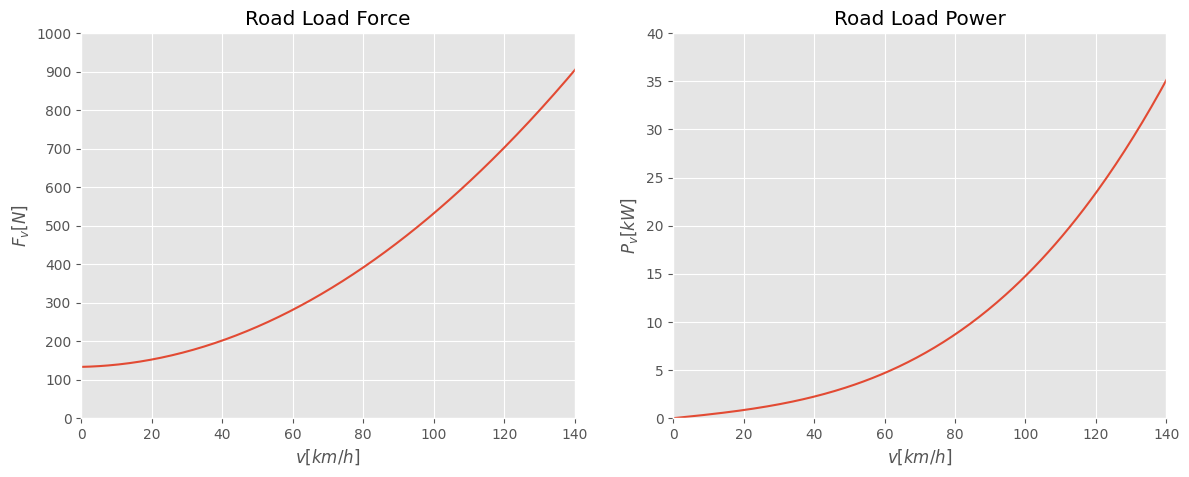

In [12]:
# ROAD LOAD FORCE AND POWER

# Davis Equation - Models the resistance forces 
# Make data
# Velocity
v = np.linspace(0, 140, 1000) # [m/s]
# Road Load Force
f_v =  (a + b * v + c * np.power(v, 2)) # [N]
# Road Load Power
p_v = (f_v * v) / 1000 # [kW]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14,5)) # 1 row, 2 columns
plt.style.use('ggplot')

# Force
ax[0].set_xlabel(r'$v  [km/h]$')
ax[0].set_ylabel(r'$F_v [N]$')
ax[0].set_title('Road Load Force')
ax[0].set_ylim(0, 1000)
ax[0].set_yticks(np.arange(0, 1100, 100))

ax[0].plot(v * (3600 / 1000), f_v)

# Power
ax[1].set_xlabel(r'$v  [km/h]$')
ax[1].set_ylabel(r'$P_v [kW]$')
ax[1].set_title('Road Load Power')
ax[1].set_ylim(0, 40)

ax[1].plot(v * (3600 / 1000), p_v)

for axe in ax:
    axe.set_xlim(0, 140)
    

plt.show()

The velocity should always be in m/s. Then in the plot change it to km/h

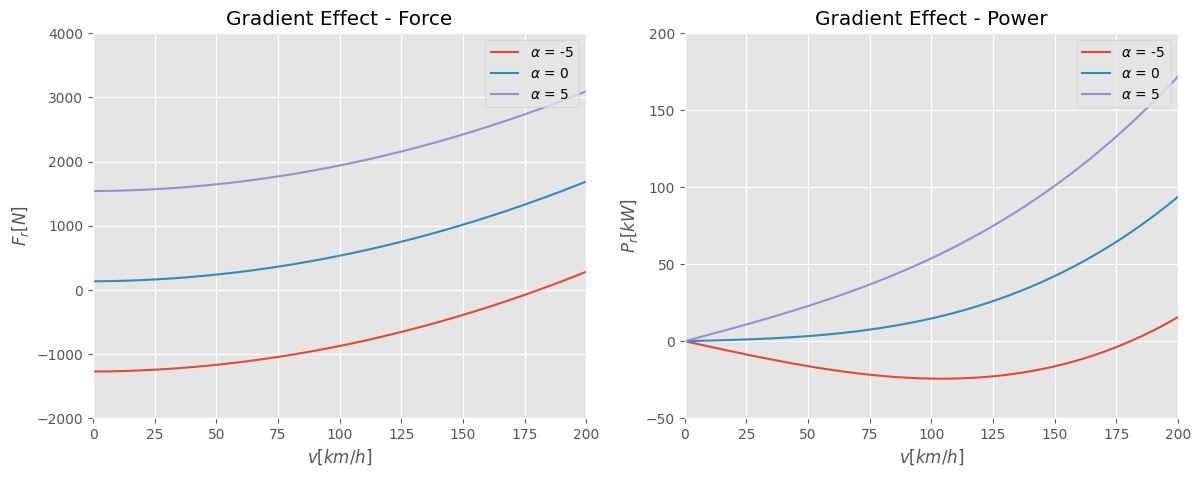

In [5]:
# GRADIENT EFFECT

# Define parameters
alphas = [-5, 0, 5]  # degrees 
v = np.linspace(0, 200, 1000) # [m/s]

# Gradient force function
def f_r(alpha):  # Takes alpha in degrees
    return  (m * g * np.sin(np.radians(alpha))) + (a + b * v + c * np.power(v, 2))

# Gradient power function
def p_r(alpha):
    return (m * g * np.sin(np.radians(alpha)) * v) / 1000 + ((a + b * v + c * np.power(v, 2)) * v) / 1000 # [kW]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns
plt.style.use('ggplot')

# Plot
ax[0].set_xlabel(r'$v  [km/h]$')
ax[0].set_ylabel(r'$F_r [N]$')
ax[0].set_title('Gradient Effect - Force')
ax[0].set_ylim(-2000, 4000)


for alpha in alphas:
    ax[0].plot(v * (3600 / 1000), np.full_like(v, f_r(alpha)), label=fr'$\alpha$ = {alpha}')
    
ax[0].legend(loc='upper right')

# Power Plot
ax[1].set_xlabel(r'$v  [km/h]$')
ax[1].set_ylabel(r'$P_r [kW]$')
ax[1].set_title('Gradient Effect - Power')
ax[1].set_ylim(-50, 200)

for alpha in alphas:
    ax[1].plot(v * 3600 / 1000, p_r(alpha), label=fr'$\alpha$ = {alpha}')

ax[1].legend(loc='upper right')


# Set limits
for axe in ax:
    axe.set_xlim(0, 200)


plt.show()

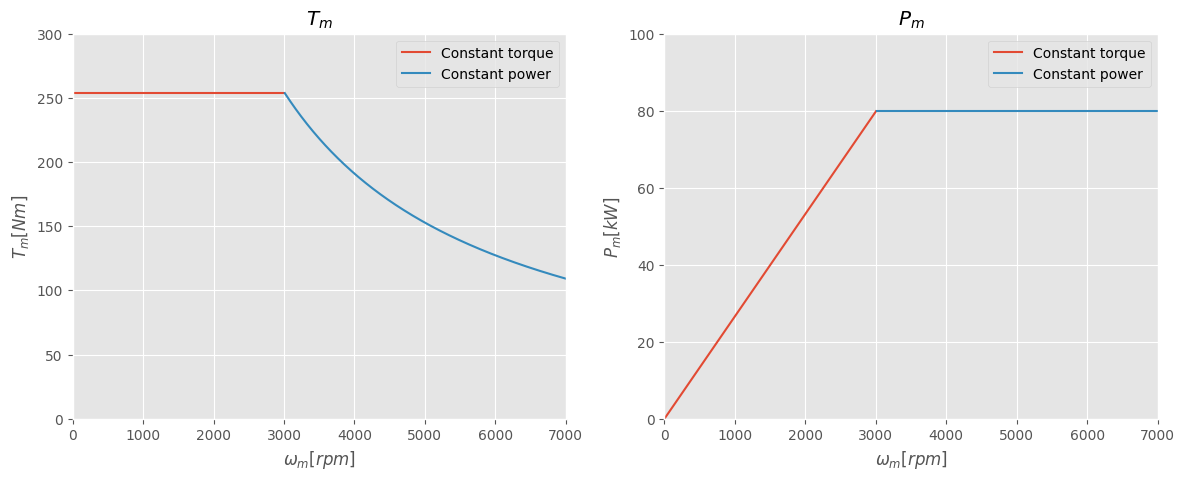

In [6]:
# Motor characteristic curve

# rad to rpm
def rads_to_rpm(rad):
    return rad * 30 / (np.pi)

# Define parameters
w_m_r = p_m_r * 1000 / (t_m_r) # [rad/s]
# Speed range
w_m = np.linspace(0.1, 1000, 1000)

# Tm
t_m = np.where(
    w_m <= w_m_r, # condition
    t_m_r, # constant toque mode
    p_m_r * 1000 / w_m # constant power mode
) # [Nm]

# Pm
p_m = np.where(
    w_m <= w_m_r,
    (t_m_r / 1000) * w_m, # constant toque mode
    p_m_r, # constant power mode
)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns
plt.style.use('ggplot')

# Torque plot
ax[0].set_xlabel(r'$\omega_m  [rpm]$')
ax[0].set_ylabel(r'$T_m [Nm]$')
ax[0].set_title(r'$T_m$')
ax[0].set_ylim(0, 300)

ax[0].plot(
    rads_to_rpm(w_m[w_m <= w_m_r]),
    np.full_like(w_m[w_m <= w_m_r], t_m[w_m <= w_m_r]),
    label='Constant torque',
)
ax[0].plot(
    rads_to_rpm(w_m[w_m > w_m_r]),
    t_m[w_m > w_m_r],
    label='Constant power',
)

# Power Plot
ax[1].set_xlabel(r'$\omega_m  [rpm]$')
ax[1].set_ylabel(r'$P_m [kW]$')
ax[1].set_title(r'$P_m$')
ax[1].set_ylim(0, 100)

ax[1].plot(
    rads_to_rpm(w_m[w_m <= w_m_r]),
    p_m[w_m <= w_m_r],
    label='Constant torque',
)
ax[1].plot(
    rads_to_rpm(w_m[w_m > w_m_r]),
    np.full_like(w_m[w_m > w_m_r], p_m[w_m > w_m_r]),
    label='Constant power',
)

# Set limits
for axe in ax:
    axe.set_xlim(0, 7000)
    axe.legend(loc='upper right')


plt.show()

In [7]:
# Resistance and Motor Power

# Define parameters
# Angles
alpha = 0# Degrees
# Initial conditions
t_max = 100
dt = 0.1
t = np.arange(0.1, t_max, dt)

# Vectors
p_r_vals = []
a_vals = []

p_r = ((m * g * np.sin(np.radians(alpha))) + ((a + b * v + c * np.power(v, 2)))) / t # [kN]


# plot
plt.figure(figsize=(12, 3))

plt.plot(t, p_r)

plt.show()


ValueError: operands could not be broadcast together with shapes (1000,) (999,) 

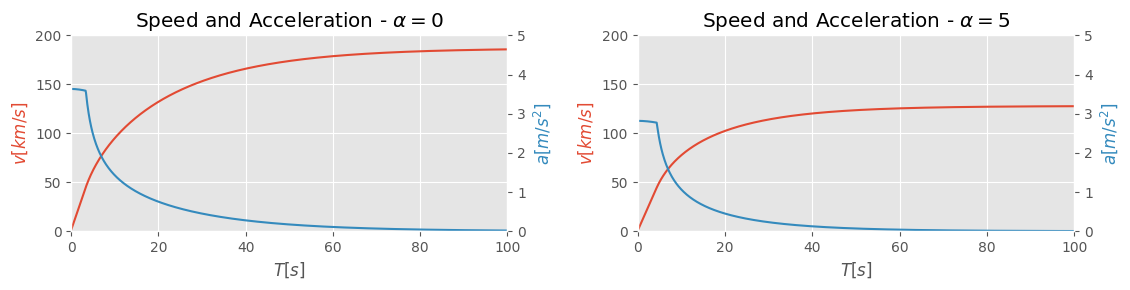

In [11]:
# Vehicle Acceleration

# Define parameters
# Angles
alpha = [0, 5] # Degrees

# Initial conditions
t_max = 100
dt = 0.1
t_vals = np.arange(0, t_max, dt)

# Vectors
v_vals = []
a_vals = []

# Numeric integration
v = 0
for t in t_vals: 
    w_m = v / (r_w * tau_g)
    t_m = t_m_r if w_m <= w_m_r else p_m_r * 1000 / w_m # [Nm]
    f_m = (eta_g * t_m) / (r_w * tau_g) # [N]
    
    
    f_v =  (m * g * math.sin(math.radians(alpha[0]))) + (a + b * v + c * math.pow(v, 2)) # [N]
    
    ac = (f_m - f_v) / (m + 0.05 * m)
    v = v + ac * dt

    
    a_vals.append(ac)
    v_vals.append(v * 3.6)

a_vals = np.array(a_vals)    
v_vals = np.array(v_vals)

# plot
plt.figure(figsize=(12, 3))

host1 = host_subplot(121)
host2 = host_subplot(122)

par1 = host1.twinx()
par2 = host2.twinx()

# plot 1
host1.set_xlabel(r'$T [s]$')
host1.set_xlim(0, 100)
host1.set_ylim(0, 200)
host1.set_ylabel(r'$v [km/s]$')
host1.set_title(r'Speed and Acceleration - $\alpha = 0$')
par1.set_ylabel(r'$a[m/s^2]$')
par1.grid(False)

p1, = host1.plot(t_vals, v_vals)
p2, = par1.plot(t_vals, a_vals)

host1.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par1.set_ylim(0, 5)

# Numeric integration
# Vectors
v_vals = []
a_vals = []
v = 0
for t in t_vals: 
    w_m = v / (r_w * tau_g)
    t_m = t_m_r if w_m <= w_m_r else p_m_r * 1000 / w_m # [Nm]
    f_m = (eta_g * t_m) / (r_w * tau_g) # [N]
    
    
    f_v =  (m * g * math.sin(math.radians(alpha[1]))) + (a + b * v + c * math.pow(v, 2)) # [N]
    
    ac = (f_m - f_v) / (m + 0.05 * m)
    v = v + ac * dt

    
    a_vals.append(ac)
    v_vals.append(v * 3.6)

a_vals = np.array(a_vals)    
v_vals = np.array(v_vals)

# plot 2
host2.set_xlabel(r'$T [s]$')
host2.set_xlim(0, 100)
host2.set_ylabel(r'$v [km/s]$')
host2.set_ylim(0, 200)
host2.set_title(r'Speed and Acceleration - $\alpha = 5$')
par2.set_ylabel(r'$a[m/s^2]$')
par2.set_ylim(0, 5)

p3, = host2.plot(t_vals, v_vals)
p4, = par2.plot(t_vals, a_vals)

par2.grid(False)

host2.yaxis.label.set_color(p3.get_color())
par2.yaxis.label.set_color(p4.get_color())

plt.subplots_adjust(right=0.85, wspace=0.1)
plt.tight_layout()
plt.show()

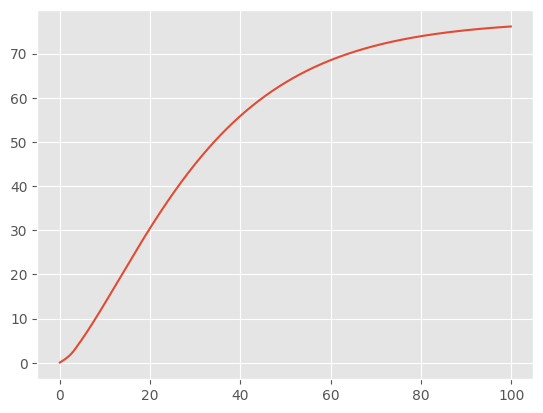

In [ ]:
# Resistance and power motor

# Define parameters
# Angles
alpha = [0, 5] # Degrees

# Initial conditions
t_max = 100
dt = 0.1
t_vals = np.arange(0, t_max, dt)

# Vectors
v_vals = []
a_vals = []

# Numeric integration
v = 0
for t in t_vals: 
    w_m = v / (r_w * tau_g)
    t_m = t_m_r if w_m <= w_m_r else p_m_r * 1000 / w_m # [Nm]
    f_m = (eta_g * t_m) / (r_w * tau_g) # [N]
    
    
    f_v =  (m * g * math.sin(math.radians(alpha[0]))) + (a + b * v + c * math.pow(v, 2)) # [N]
    
    ac = (f_m - f_v) / (m + 0.05 * m)
    v = v + ac * dt

    
    a_vals.append(ac)
    v_vals.append(v) # let this vector in [km/h]

a_vals = np.array(a_vals)    
v_vals = np.array(v_vals)

# Gradient force function
def f_r(alpha):  # Takes alpha in degrees
    return  (m * g * np.sin(np.radians(alpha))) + (a + b * v + c * np.power(v_vals, 2)) * v_vals



fig, ax = plt.subplots()


ax.plot(t_vals, f_r(0) / 1000)


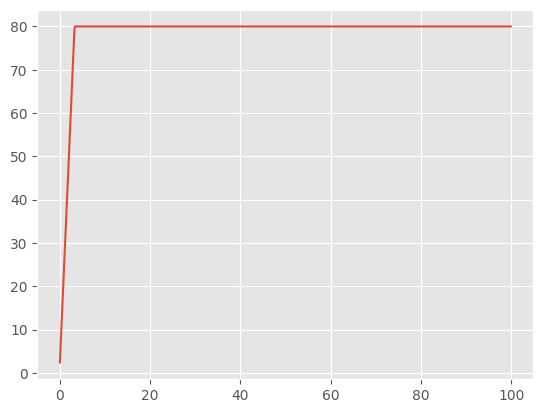

In [ ]:
# Resistance and power motor

# Define parameters
# Angles
alpha = [0, 5] # Degrees

# Initial conditions
t_max = 100
dt = 0.1
t_vals = np.arange(0, t_max, dt)

# Vectors
v_vals = []
a_vals = []

# Numeric integration
v = 0
for t in t_vals: 
    w_m = v / (r_w * tau_g)
    t_m = t_m_r if w_m <= w_m_r else p_m_r * 1000 / w_m # [Nm]
    f_m = (eta_g * t_m) / (r_w * tau_g) # [N]
    
    
    f_v =  (m * g * math.sin(math.radians(alpha[0]))) + (a + b * v + c * math.pow(v, 2)) # [N]
    
    ac = (f_m - f_v) / (m + 0.05 * m)
    v = v + ac * dt

    
    a_vals.append(ac)
    v_vals.append(v) # let this vector in [km/h]

a_vals = np.array(a_vals)    
v_vals = np.array(v_vals)


w_vals = v_vals / (r_w * tau_g)


# Define parameters
w_m_r = p_m_r * 1000 / (t_m_r) # [rad/s]
# Speed range
w_m = np.linspace(0.1, 1000, 1000)

# Tm
t_m = np.where(
    w_vals <= w_m_r, # condition
    t_m_r, # constant toque mode
    p_m_r * 1000 / w_vals # constant power mode 
) # [Nm]

# Pm
p_m = np.where(
    w_vals <= w_m_r,
    (t_m_r / 1000) * w_vals, # constant toque mode
    p_m_r, # constant power mode
)


fig, ax = plt.subplots()


ax.plot(t_vals, p_m)